<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-1:-Introduction" data-toc-modified-id="Figure-1:-Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 1: Introduction</a></span></li><li><span><a href="#Figure-2:-Model-Performance" data-toc-modified-id="Figure-2:-Model-Performance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 2: Model Performance</a></span><ul class="toc-item"><li><span><a href="#Load-KaiABC-model" data-toc-modified-id="Load-KaiABC-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load KaiABC model</a></span><ul class="toc-item"><li><span><a href="#Estimate-Errors" data-toc-modified-id="Estimate-Errors-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Estimate Errors</a></span></li></ul></li><li><span><a href="#Plot-KaiABC-model-with-$N_{\rm-eff}$" data-toc-modified-id="Plot-KaiABC-model-with-$N_{\rm-eff}$-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plot KaiABC model with $N_{\rm eff}$</a></span></li></ul></li><li><span><a href="#Figure-3:-Plot-all-data-together" data-toc-modified-id="Figure-3:-Plot-all-data-together-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 3: Plot all data together</a></span></li><li><span><a href="#Figure-4:-New-Model" data-toc-modified-id="Figure-4:-New-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 4: New Model</a></span></li><li><span><a href="#Supplemental-Plots" data-toc-modified-id="Supplemental-Plots-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Supplemental Plots</a></span></li></ul></div>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal
import pandas as pd
import pickle
from matplotlib.backends import backend_pdf as bpdf
from kaic_analysis.scripts import FirstPassage, RunModel, Current, StateData, FindParam, LoadExperiment, PlotExperiment, EntropyRate
from kaic_analysis.toymodel import SimulateClockKinetic
import os
from sklearn.decomposition import PCA
import seaborn as sns
import scipy.interpolate as interpolate
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import scipy.optimize as opt
%matplotlib inline

def var(values, axis=1):
    '''Returns the variance of each row of a matrix'''
    return np.var(np.asmatrix(values), axis=axis).A1

def compute_maxeig(A,C,N):
    K0 = np.asarray([[-C*N*(np.sin(2*np.pi*(i-1-j)/N)-np.sin(2*np.pi*(i-j)/N))*(1-np.exp(-A/N)) for j in range(N)] for i in range (N)])
    K1 = np.diag(np.ones(N-1),k=1)*N - np.eye(N)*N*(1+np.exp(-A/N)) + np.diag(np.ones(N-1),k=-1)*N*np.exp(-A/N)
    K = K0 + K1
    Keig = np.linalg.eig(K)[0]
    max_ind = np.argmax(np.real(Keig))
    return np.real(Keig[max_ind])

def compute_maxeig_imag(A,C,N):
    K0 = np.asarray([[-C*N*(np.sin(2*np.pi*(i-1-j)/N)-np.sin(2*np.pi*(i-j)/N))*(1-np.exp(-A/N)) for j in range(N)] for i in range (N)])
    K1 = np.diag(np.ones(N-1),k=1)*N - np.eye(N)*N*(1+np.exp(-A/N)) + np.diag(np.ones(N-1),k=-1)*N*np.exp(-A/N)
    K = K0 + K1
    Keig = np.linalg.eig(K)[0]
    max_ind = np.argmax(np.real(Keig))
    return np.imag(Keig[max_ind])

# Figure 1: Introduction

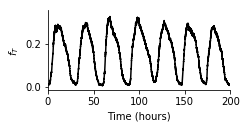

In [2]:
fig,ax = plt.subplots(figsize=(3.25,1.75))
fig.subplots_adjust(left=0.17,bottom=0.25,right=0.95)

code_folder = '../KMC_KaiC_rev2'
data_low=RunModel(folder=code_folder,paramdict={'volume':1,'sample_cnt':1e4,'tequ':50,'rnd_seed':np.random.randint(1e6),'ATPfrac':0.45},name='data_low')
data_WT=RunModel(folder=code_folder,paramdict={'volume':1,'sample_cnt':3e5,'tequ':50,'rnd_seed':np.random.randint(1e6)},name='data_WT')
os.chdir('../data')

data_WT.index = data_WT.index-data_WT.index[0]
(data_WT['pT']/6).plot(ax=ax,color='k',legend=False)

ax.set_xlim((0,200))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Time (hours)')
ax.set_ylabel(r'$f_T$')
pdf = bpdf.PdfPages('Plots/timeseries_kaic.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

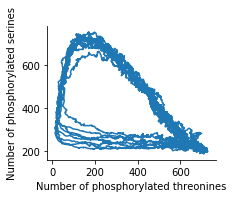

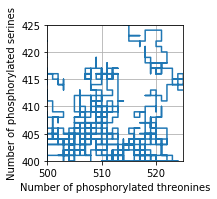

In [3]:
nT = data_WT['pT'].values*360 #volume = 1 corresponds to 360 hexamers
nS = data_WT['pS'].values*360
samp = np.arange(100000,300000,20,dtype=int)

fig,ax = plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.17,bottom=0.25,right=0.95)
ax.plot(nT[samp],nS[samp])
ax.set_aspect('equal', 'box')
ax.set_xlabel('Number of phosphorylated threonines')
ax.set_ylabel('Number of phosphorylated serines')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pdf = bpdf.PdfPages('Plots/limit.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

fig,ax = plt.subplots(figsize=(3,3))
fig.subplots_adjust(left=0.17,bottom=0.25,right=0.9)
ax.plot(nT[100000:],nS[100000:])
ax.set_xlim((500,525))
ax.set_ylim((400,425))
ax.set_aspect('equal', 'box')
ax.set_xlabel('Number of phosphorylated threonines')
ax.set_ylabel('Number of phosphorylated serines')
ax.grid(True)
pdf = bpdf.PdfPages('Plots/zoom.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

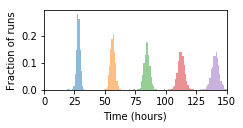

In [4]:
param_name = 'ATPfrac'
run_nums = list(range(17,22))
fig,ax = plt.subplots(figsize=(3.25,1.75))
fig.subplots_adjust(left=0.17,bottom=0.25,right=0.95)

data = LoadExperiment(param_name,run_nums,date='2018-08-24',folder='kaic_data')

bins = np.linspace(0,150,150)

name = 'ATPfrac = 0.99999998477'
for Ncyc in range(1,6):
    ax.hist(FirstPassage(data[2][name],Ncyc=Ncyc),bins=bins,density=True,alpha=0.5)
ax.set_xlim((0,150))
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Fraction of runs')
pdf = bpdf.PdfPages('Plots/hist.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

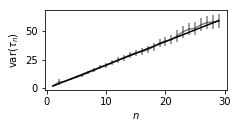

In [7]:
Ncyclist = np.arange(1,30)

fig,ax = plt.subplots(figsize=(3.25,1.75))
fig.subplots_adjust(left=0.17,bottom=0.25,right=0.95)

ax.set_xlabel(r'$n$')
ax.set_ylabel(r'${\rm var}(\tau_n)$')



vartau = []
meantau = []
varw=[]
meanw=[]
for N in Ncyclist:
    taus = np.asarray(FirstPassage(data[2][name],Ncyc=N))
    bs_mean = bs.bootstrap(taus,stat_func=bs_stats.mean)
    bs_var = bs.bootstrap(taus,stat_func=var)
    vartau.append(bs_var.value)
    meantau.append(bs_mean.value)
    varw.append(2./(bs_var.upper_bound-bs_var.lower_bound))
    meanw.append(2./(bs_mean.upper_bound-bs_mean.lower_bound))
    
varw = np.asarray(varw)
meanw=np.asarray(meanw)
vartau = np.asarray(vartau)
meantau = np.asarray(meantau)
    
[slope, intercept], cov = np.polyfit(Ncyclist,vartau,1,w=varw,cov=True)
ax.errorbar(Ncyclist,np.asarray(vartau),yerr=1/np.asarray(varw),color='k',alpha=0.5)
ax.plot(Ncyclist,intercept+slope*Ncyclist,color='k')

pdf = bpdf.PdfPages('Plots/D.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Figure 2: Model Performance

## Load KaiABC model

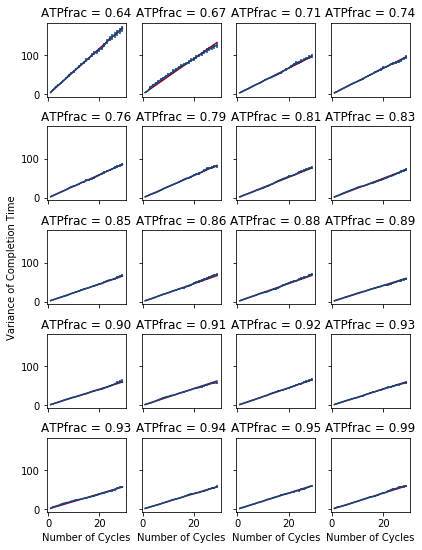

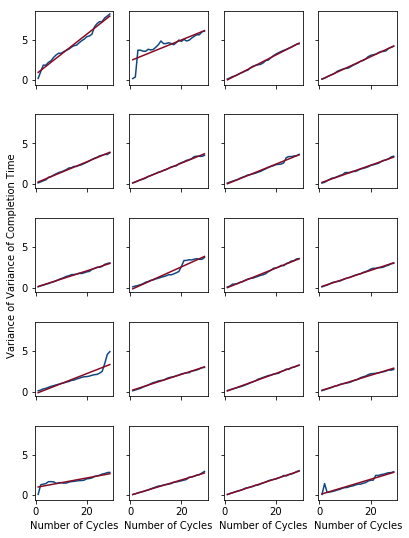

In [10]:
param_name = 'ATPfrac'
run_nums = list(range(1,13))
data = LoadExperiment(param_name,run_nums,date='2018-08-23',folder='kaic_data')[2]
run_nums = list(range(13,22))
data.update(LoadExperiment(param_name,run_nums,date='2018-08-24',folder='kaic_data')[2])

keylist = list(data.keys())
ATPfracs = [Decimal(keylist[j].split('=')[1]) for j in range(len(keylist))]
ATPfracs.sort()
namelist = [param_name+' = '+str(ATPfracs[j]) for j in range(len(ATPfracs))]

Ncyclist = np.arange(1,30)
D0 = []
D0_err = []
D0_2 = []
D0_2_err = []
T = []
vary = []
colors = sns.color_palette("RdBu_r",21)

fig,axs = plt.subplots(5,4,figsize=(6.5,9),sharex=True,sharey=True)
for k in range(4):
    axs[4,k].set_xlabel('Number of Cycles')
axs[2,0].set_ylabel('Variance of Completion Time')

axs = axs.reshape(-1)
fig.subplots_adjust(hspace=0.4)

fig2,ax2 = plt.subplots(5,4,figsize=(6.5,9),sharex=True,sharey=True)
for k in range(4):
    ax2[4,k].set_xlabel('Number of Cycles')
ax2[2,0].set_ylabel('Variance of Variance of Completion Time')
ax2 = ax2.reshape(-1)
fig2.subplots_adjust(hspace=0.4)

k = 0

for name in namelist[1:]:

    vartau = []
    meantau = []
    varw=[]
    meanw=[]
    for N in Ncyclist:
        taus = np.asarray(FirstPassage(data[name],Ncyc=N))
        bs_mean = bs.bootstrap(taus,stat_func=bs_stats.mean,alpha=0.36)
        bs_var = bs.bootstrap(taus,stat_func=var,alpha=0.36)
        vartau.append(bs_var.value)
        meantau.append(bs_mean.value)
        varw.append(2./(bs_var.upper_bound-bs_var.lower_bound))
        meanw.append(2./(bs_mean.upper_bound-bs_mean.lower_bound))
    
    varw = np.asarray(varw)
    meanw=np.asarray(meanw)
    vartau = np.asarray(vartau)
    meantau = np.asarray(meantau)
    
    ax2[k].plot(Ncyclist,1./varw,color = colors[0])
    slope, intercept = np.polyfit(Ncyclist,1./varw,1)
    ax2[k].plot(Ncyclist,intercept+slope*Ncyclist,color=colors[-1])
    vary.append(slope**2)
    
    slope, intercept = np.polyfit(Ncyclist,meantau,1,w=meanw)
    T.append(slope)
    
    [slope, intercept], cov = np.polyfit(Ncyclist,vartau,1,w=varw,cov=True)
    D0.append(slope)
    D0_2.append(vartau[-1]/Ncyclist[-1])
    cov = np.linalg.inv(np.asarray([[2*np.sum(varw**2*Ncyclist**2),2*np.sum(varw**2*Ncyclist)],
                                   [2*np.sum(varw**2*Ncyclist),2*np.sum(varw**2)]]))
    D0_err.append(np.sqrt(cov[0,0]))
    D0_2_err.append(np.sqrt(1./varw[-1]))
    axs[k].errorbar(Ncyclist,np.asarray(vartau),yerr=1/np.asarray(varw),color=colors[0])
    axs[k].plot(Ncyclist,intercept+slope*Ncyclist,color=colors[-1])
    axs[k].set_title(name[:14])
    k+=1
    
pdf = bpdf.PdfPages('Plots/KaiC_fits.pdf')
pdf.savefig(fig)
pdf.close()

pdf = bpdf.PdfPages('Plots/KaiC_fits_var.pdf')
pdf.savefig(fig2)
pdf.close()
plt.show()

T = np.asarray(T)
D = np.asarray(D0)/T
D_err = np.asarray(D0_err)/T
D2 = np.asarray(D0_2)/T
D2_err = np.asarray(D0_2_err)/T
D3_err = np.sqrt(np.asarray(vary))/T


run_nums = list(range(1,13))
data = LoadExperiment(param_name,run_nums,date='2018-08-23',folder='kaic_data')[1]
run_nums = list(range(13,22))
data = data.join(LoadExperiment(param_name,run_nums,date='2018-08-24',folder='kaic_data')[1])

Scyc = data[namelist].values[0][1:]*T

with open('ModelData.dat', 'wb') as f:
    pickle.dump([T, D, D_err, Scyc],f)

### Estimate Errors

The graphs of the bootstrap error versus number of cycles indicate that the standard deviation of the completion time increases linearly with the number of cycles. This is what we would expect to happen if each run of the experiment (making the same number of trajectories and estimating the variance for each number of cycles) produces a slope $D_0+y$, where $y$ has mean 0 and variance $\sigma_y^2$, and is fixed for each iteration of the simulation.

Specifically, we have
\begin{align}
{\rm var}(\tau_n) &= (D_0 + y)N_{\rm cyc}\\
\sqrt{{\rm var}({\rm var}(\tau_n))} &= \sigma_y N_{\rm cyc}.
\end{align}

Under this noise model, the uncertainty in the slope is simply $\sigma_y$.

## Plot KaiABC model with $N_{\rm eff}$

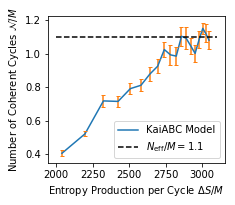

In [11]:
with open('ModelData.dat','rb') as f:
    [T,D,D_err,Scyc] = pickle.load(f)
    
DelWmin = 2000
DelWmax = 3100
DelWvec = np.exp(np.linspace(np.log(DelWmin),np.log(DelWmax),5000))

M = 180*2
Neff = 1.1
Ncoh = T/D
Ncoh_err = (T/D**2)*D3_err
k=0

Scyc = Scyc[:-1]
Ncoh = Ncoh[:-1]
Ncoh_err = Ncoh_err[:-1]

fig,ax=plt.subplots(figsize=(3.5,3))
fig.subplots_adjust(left=0.2,bottom=0.2)
ax.plot(Scyc/M,Ncoh/M,label='KaiABC Model')
ax.errorbar(Scyc/M,Ncoh/M,yerr=Ncoh_err/M,linestyle='',capsize=2)
ax.plot([DelWmin,DelWmax],[Neff,Neff],'k--',label = r'$N_{\rm eff}/M = $'+str(Neff))
plt.legend(loc=4)

ax.set_xlabel(r'Entropy Production per Cycle $\Delta S/M$')
ax.set_ylabel(r'Number of Coherent Cycles $\mathcal{N}/M$')

pdf = bpdf.PdfPages('Plots/Figure2.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

# Figure 3: Plot all data together

Empirical curve:
\begin{align}
\frac{V}{\mathcal{N}} - C &= W_0 (W-W_c)^\alpha\\
\frac{\mathcal{N}}{V} &= \frac{1}{C+ W_0(W-W_c)^\alpha}
\end{align}

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


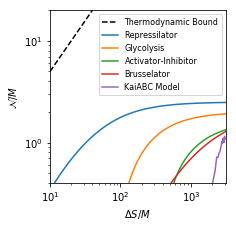

In [12]:
with open('ModelData.dat','rb') as f:
    [T,D,D_err,Scyc] = pickle.load(f)

def CaoN(DelW,params = {}):
    N = (params['C']+params['W0']*(DelW-params['Wc'])**params['alpha'])**(-1)
    N[np.where(DelW<params['Wc'])[0]] = np.nan
    return N

#For comparing experiment data:
VKai = 3e13 #Convert volume to single hexamers (assuming 3.4 uM concentration of monomers, and 100 uL wells)
al = 1/(2*np.pi**2)

#Parameters from Cao2015
paramlist = {'Activator-Inhibitor':
                {'C':0.6,
                 'W0':380,
                 'Wc':360,
                 'alpha':-0.99},
             'AI Envelope':
                {'C':0.36,
                 'W0':194,
                 'Wc':400,
                 'alpha':-1},
             'Repressilator':
                 {'Wc':1.75,
                  'W0':25.9,
                  'alpha':-1.1,
                  'C':0.4},
             'Brusselator':
                 {'Wc':100.4,
                  'W0':846,
                  'alpha':-1.0,
                  'C':0.5},
             'Glycolysis':
                 {'Wc':80.5,
                  'W0':151.4,
                  'alpha':-1.1,
                  'C':0.5},
              'KaiABC Experiment':
                 {'Wc':10.6*16*6,
                  'W0':0.28*16*6*VKai*al,
                  'alpha':-1.0,
                  'C':0.04*VKai*al}}

fig,ax=plt.subplots(figsize=(3.25,3))
fig.subplots_adjust(bottom=0.15,left=0.2,right=0.95,top=0.95)
del paramlist['AI Envelope']
del paramlist['KaiABC Experiment']
DelWmin = 1
DelWmax = 0.6*10000
DelWvec = np.exp(np.linspace(np.log(DelWmin),np.log(DelWmax),5000))
ax.plot(DelWvec,DelWvec/2,'k--',label='Thermodynamic Bound')
for item in ['Repressilator','Glycolysis','Activator-Inhibitor','Brusselator']:
    ax.plot(DelWvec,CaoN(DelWvec,params=paramlist[item]),label=item)

N = 1
M = 180*2
Neff = 1.2*N*M
Ncoh = T/D
Ncoh_err = (T/D**2)*D_err
k=0

ax.plot(Scyc[:-1]/M,Ncoh[:-1]/M,label='KaiABC Model')

plt.legend(loc=1,fontsize=8)
ax.set_ylim((4e-1,2e1))
ax.set_xlim((10,3100))
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'$\Delta S/M$')
ax.set_ylabel(r'$\mathcal{N}/M$')

pdf = bpdf.PdfPages('Plots/Figure3.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()



# Figure 4: New Model

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars


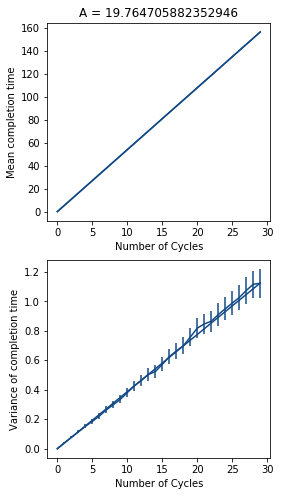

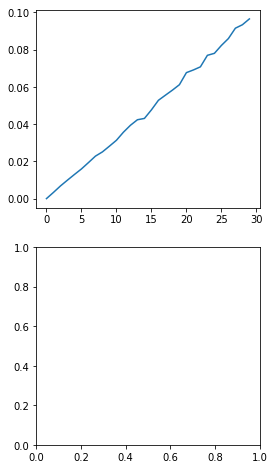

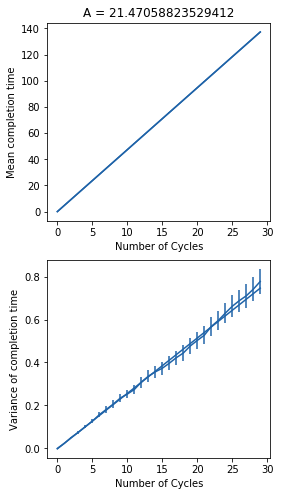

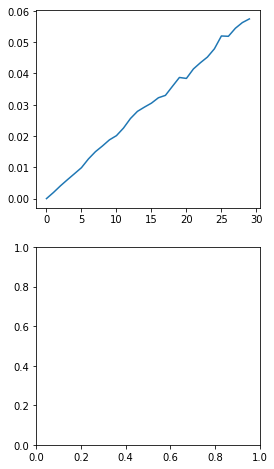

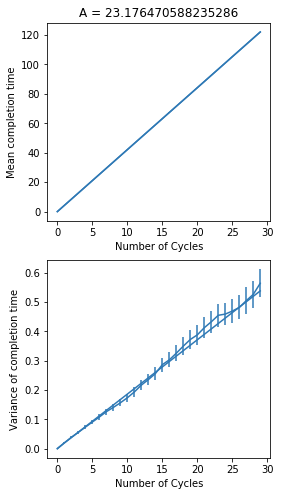

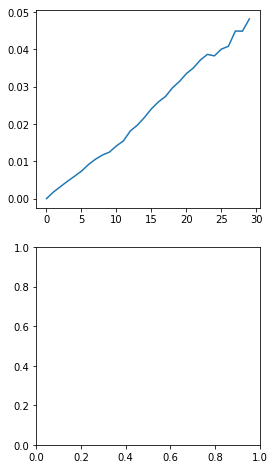

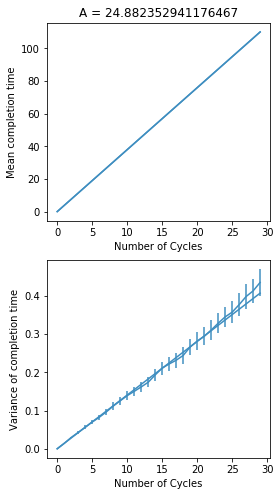

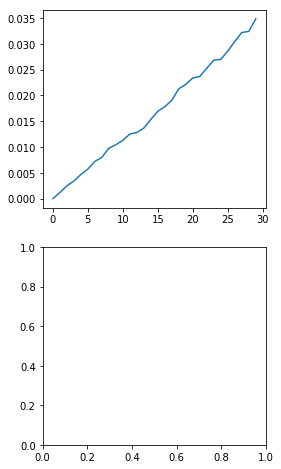

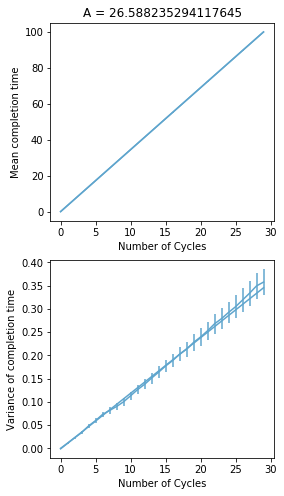

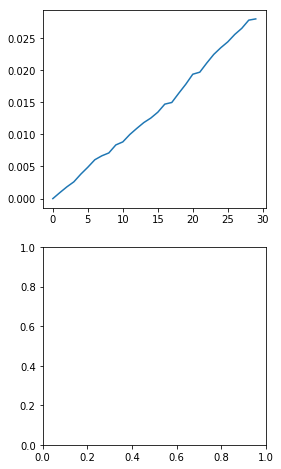

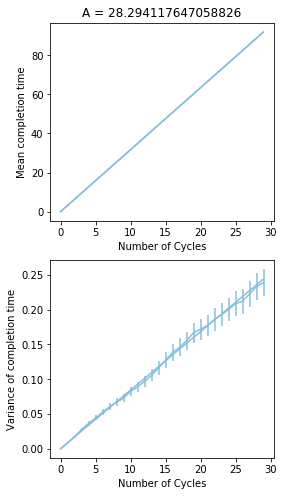

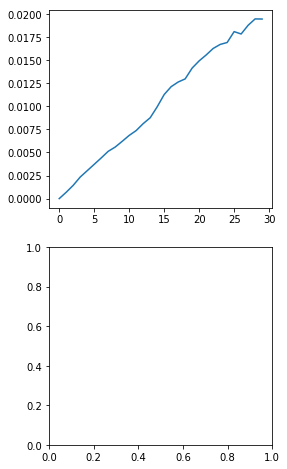

In [16]:
date = '2018-08-23'
date2 = '2018-08-24'
date3 = '2018-08-25'
D0 = []
D0_err = []
T = []
Scyc = []
sigy =[]
colors = sns.color_palette("RdBu_r",20)
k = 0
for expt_number in range(3):
    low = 18*expt_number+1
    high = 18*(expt_number+1)
    if expt_number == 2: #Skip simulations that failed
        low = 48
    for run_number in range(low,high):
        try:
            t = pd.read_csv('toy_data/t_'+date+'_'+str(run_number)+'.csv',header=None)
            t = t - t.loc[0]
            data = pd.read_csv('toy_data/data_'+date+'_'+str(run_number)+'.csv',index_col=0)
        except:
            try:
                t = pd.read_csv('toy_data/t_'+date2+'_'+str(run_number)+'.csv',header=None)
                t = t - t.loc[0]
                data = pd.read_csv('toy_data/data_'+date2+'_'+str(run_number)+'.csv',index_col=0)
            except:
                t = pd.read_csv('toy_data/t_'+date3+'_'+str(run_number)+'.csv',header=None)
                t = t - t.loc[0]
                data = pd.read_csv('toy_data/data_'+date3+'_'+str(run_number)+'.csv',index_col=0)


        fig,axs = plt.subplots(2,figsize=(4,8))
        fig2,axs2 = plt.subplots(2,figsize=(4,8))
        vartau = []
        meantau = []
        varw=[]
        meanw=[]
        sigy=[]
        
        for N in t.index:
            taus = t.loc[N].values
            bs_mean = bs.bootstrap(taus,stat_func=bs_stats.mean)
            bs_var = bs.bootstrap(taus,stat_func=var)
            vartau.append(bs_var.value)
            meantau.append(bs_mean.value)
            varw.append(2./(bs_var.upper_bound-bs_var.lower_bound))
            meanw.append(2./(bs_mean.upper_bound-bs_mean.lower_bound))
   
        varw = np.asarray(varw)
        meanw=np.asarray(meanw)
        vartau = np.asarray(vartau)
        meantau = np.asarray(meantau)
    
        usable = np.where(~np.isnan(meantau))[0]
        usable = usable[1:]
    
        try:
            slope, intercept = np.polyfit(t.index.values[usable],meantau[usable],1,w=meanw[usable])
            T.append(slope)
            axs[0].set_title('A = '+str(data['A'].loc[0]))
            axs[0].errorbar(t.index,meantau,yerr=1/meanw,color=colors[k])
            axs[0].plot(t.index,intercept+slope*t.index,color=colors[k])
            axs[0].set_xlabel('Number of Cycles')
            axs[0].set_ylabel('Mean completion time')
            
            axs2[0].plot(t.index,1./varw)
            [slope, intercept], cov = np.polyfit(t.index.values[usable],1./varw[usable],1,cov=True)
            sigy.append(slope)
    
            [slope, intercept], cov = np.polyfit(t.index.values[usable],vartau[usable],1,w=varw[usable],cov=True)
            D0.append(slope)
            cov = np.linalg.inv(np.asarray([[np.nansum(varw[usable]**2*t.index.values[usable]**2),np.nansum(varw[usable]**2*t.index.values[usable])],
                                       [np.nansum(varw[usable]**2*t.index.values[usable]),np.nansum(varw[usable]**2)]]))

            D0_err.append(np.sqrt(cov[0,0]))
            axs[1].errorbar(t.index,np.asarray(vartau),yerr=1/np.asarray(varw),color=colors[k])
            axs[1].plot(t.index,intercept+slope*t.index,color=colors[k])
            axs[1].set_xlabel('Number of Cycles')
            axs[1].set_ylabel('Variance of completion time')
            Scyc.append(data['Sdot'].mean()*T[-1])
            k+=1
        except:
            print(str(run_number)+' failed!')
            try:
                del T[k]
            except:
                e = 1
            try:
                del D0[k]
            except:
                e = 1
    
        plt.show()
    

    T = np.asarray(T)
    D = np.asarray(D0)/T
    D_err = np.asarray(sigy)/T

    Scyc = np.asarray(Scyc)
    with open('ToyData_'+str(expt_number)+'_2.dat', 'wb') as f:
        pickle.dump([T, D, D_err, Scyc],f)

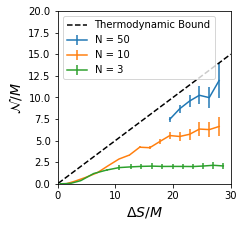

In [17]:
fig,ax=plt.subplots(figsize=(3.25,3))
fig.subplots_adjust(bottom=0.15,left=0.21,right=0.95,top=0.95)
colors = sns.color_palette()

xvec = np.exp(np.linspace(-2,np.log(30),120))
Nlist = [3,10,50]
M = 100
colors = sns.color_palette()
k=0
for n in [2,1,0]:
    with open('ToyData_'+str(n)+'_2.dat', 'rb') as f:
        [T, D, D_err, Scyc] = pickle.load(f)
    N = Nlist[n]
    Neff = 1.3*N*M
    Ncoh = T/D
    Ncoh_err = 2*(T/D**2)*D_err

    ax.errorbar(Scyc/M,Ncoh/M,yerr=Ncoh_err/M,color=colors[k],label='N = '+str(N))    
    k+=1
ax.plot(xvec,xvec/2,'--',color='k',label='Thermodynamic Bound')
plt.legend(loc=2,fontsize=10)
ax.set_xlim((0,30))
ax.set_ylim((0,20))


ax.set_xlabel(r'$\Delta S/M$',fontsize=14)
ax.set_ylabel(r'$\mathcal{N}/M$',fontsize=14)

pdf = bpdf.PdfPages('Plots/toymodel.pdf')
pdf.savefig(fig)
pdf.close()

plt.show()

# Supplemental Plots

In [41]:
data = []
N = 6
M = 100
C = 5
kwargs = {'tmax':4,'nsteps':1,'N':N,'M':M,'A':4.4,'C':C}
out1 = SimulateClockKinetic(**kwargs)
kwargs = {'tmax':4,'nsteps':1,'N':N,'M':M,'A':9.529,'C':C}
out2 = SimulateClockKinetic(**kwargs)

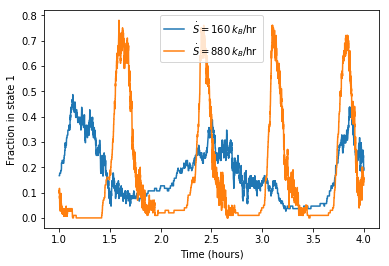

In [42]:
fig,ax=plt.subplots()
ax.plot(out1['t'],out1['f'][:,0], label=r'$\dot{S} = 160\,k_B/{\rm hr}$')
ax.plot(out2['t'],out2['f'][:,0], label=r'$\dot{S} = 880\,k_B/{\rm hr}$')
plt.legend()
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Fraction in state 1')
pdf = bpdf.PdfPages('Plots/timeseries_new.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

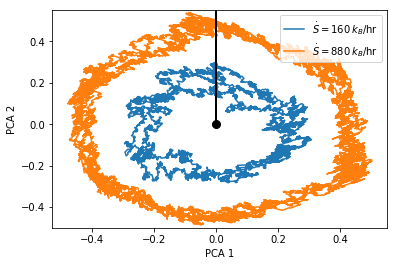

In [43]:
fig,ax=plt.subplots()

N = 6
M = 100
C = 5

skip = 1
model = PCA(n_components=2).fit(out1['f'])
f1 = model.transform(out1['f'])
ax.plot(f1[np.arange(0,len(f1),skip),0],f1[np.arange(0,len(f1),skip),1],label=r'$\dot{S} = 160\,k_B/{\rm hr}$')

skip = 1
model = PCA(n_components=2).fit(out2['f'])
f2 = model.transform(out2['f'])
ax.plot(f2[np.arange(0,len(f2),skip),0],f2[np.arange(0,len(f2),skip),1],label=r'$\dot{S} = 880\,k_B/{\rm hr}$')

ax.plot([0],[0],'ko',markersize=8)
ax.plot([0,0],[0,0.6],'k',linewidth=2)
ax.set_ylim((-0.5,0.55))

plt.legend(loc=1)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
pdf = bpdf.PdfPages('Plots/phase_new.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

In [31]:
Cvec = np.arange(2,7)
Acvec = {}
period = {}
Nvec = np.arange(3,50)


for C in Cvec:
    Acvec.update({'C = '+str(C): []})
    period.update({'C = '+str(C): []})
    for N in Nvec:
        try:
            Acvec['C = '+str(C)].append(opt.brentq(compute_maxeig,0,2,args=(C,N)))
            period['C = '+str(C)].append(2*np.pi/compute_maxeig_imag(Acvec['C = '+str(C)][-1],C,N))
        except:
            Acvec['C = '+str(C)].append(np.nan)
            period['C = '+str(C)].append(np.nan)
        
with open('Ac2.dat','wb') as f:
    pickle.dump([Nvec,Acvec,period],f)

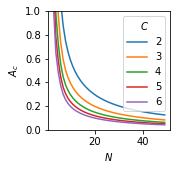

In [32]:
with open('Ac2.dat','rb') as f:
    Nvec,Acvec,period = pickle.load(f)
    
fig,ax=plt.subplots(figsize=(2.5,2.5))
fig.subplots_adjust(left=0.22,bottom=0.22)
for item in Acvec.keys():
    ax.plot(Nvec,Acvec[item],label=item[-1])
plt.legend(title = r'$C$')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$A_c$')
ax.set_ylim((0,1))

pdf = bpdf.PdfPages('Plots/Figure6b.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

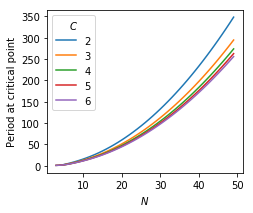

In [33]:
fig,ax=plt.subplots(figsize=(3.5,3))
for item in Acvec.keys():
    ax.plot(Nvec,period[item],label=item[-1])
plt.legend(title = r'$C$')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'Period at critical point')
pdf = bpdf.PdfPages('Plots/Figure5c.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()